In [1]:
import mne 
import os
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt
from src.utils import get_bids_file
from src.params import PREPROC_PATH, FREQS_LIST, FREQS_NAMES, EVENTS_ID, RESULT_PATH
from mne.time_frequency import (tfr_morlet, AverageTFR)



In [10]:
def compute_hilbert_psd(evoked, event_id, freq, freq_name, picks, task, condition) :
    evoked.pick_types(meg=True, ref_meg = False,  exclude='bads')
    epochs = evoked.average()
    
    l_freq = freq[0]
    h_freq = freq[1]

    epochs_filter = epochs.copy()
    epochs_filter.filter(l_freq, h_freq, picks = picks)
    epochs_hilbert = epochs_filter.apply_hilbert(picks = picks, envelope=True)

    tfr_data = epochs_hilbert.get_data()
    tfr_data = tfr_data * tfr_data.conj()  # compute power
    tfr_data = np.mean(tfr_data, axis=0)  # average over epochs
    
    tfr_data._data = hilbert._data**2
    data[:, idx] = tfr_data
    power = AverageTFR(info, data, epochs.times, freqs, nave=n_epochs)

    power.plot([0], baseline=(0., 0.1), mode='mean', vmin=-0.1, vmax=0.1,
               axes=ax, show=False, colorbar=False)

    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title('Sim: Using narrow bandpass filter Hilbert,\n'
                 f'bandwidth = {bandwidth}, '
                 f'transition bandwidth = {4 * bandwidth}')
    plt.tight_layout()

    # Save
    _, save_psd = get_bids_file(RESULT_PATH, task=task, stage="psd-hilbert", condition=condition, measure=freq_name)

    with open(save_psd, "wb") as f:
        pickle.dump(epochs_psd, f)

    return epochs_psd

In [13]:
def compute_morlet_psd(epochs, event_id, freq, freq_name, picks, task, condition) :
        
    epochs.pick_types(meg=True, ref_meg = False,  exclude='bads')
    epochs = evoked.average()

    # Morlet wavelet
    n_cycles = freq / 2.
    power = tfr_morlet(epochs, freqs=freq,
                    n_cycles=n_cycles, return_itc=False, average=True, picks=picks)
    print(type(power))
    print(power)

    _, save_psd = get_bids_file(RESULT_PATH, task=task, stage="psd-morlet", condition=condition, measure=freq_name)
    
    with open(save_psd, "wb") as f:
        pickle.dump(power, f)

    power.plot([0], baseline=(0., 0.1), mode='mean', vmin=-3, vmax=3,
              title='Using Morlet wavelets and EpochsTFR', show=False)
    plt.show()

    return power

In [4]:
def plot_psd(epochs) :

    _, ax = plt.subplots()
    spectrum = epochs.compute_psd(fmin=2., fmax=40., tmax=3., n_jobs=None)
    print(spectrum)
    # average across epochs first
    mean_spectrum = spectrum.average()
    psds, freqs = spectrum.get_data(return_freqs=True)
    # then convert to dB and take mean & standard deviation across channels
    psds = 10 * np.log10(psds)
    psds_mean = psds.mean(axis=0)
    psds_std = psds.std(axis=0)

    ax.plot(freqs, psds_mean, color='k')
    ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                    color='k', alpha=.5, edgecolor='none')
    
    ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
           ylabel='Power Spectral Density (dB)')

=> Process task : LaughterActive condition : LaughReal frequency : [ 8 12]
Removing 5 compensators from info because not all compensation channels were picked.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    0.4s finished


<class 'mne.time_frequency.tfr.AverageTFR'>
<AverageTFR | time : [-0.500000, 1.500000], freq : [8.000000, 12.000000], nave : 1, channels : 270, ~11.0 MB>
Applying baseline correction (mode: mean)


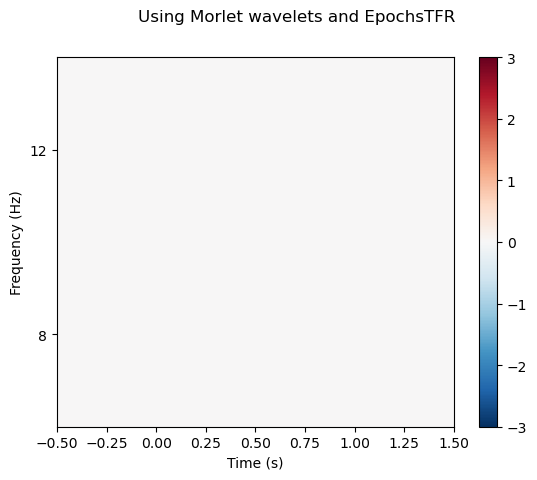

In [15]:

# Conditions and task to compute
task = "LaughterActive"
condition = "LaughReal"
freq_name = 'alpha'

condition_list = [condition]
event_id = dict()
picks = "meg" # Select MEG channels

for ev in EVENTS_ID :
    for conds in condition_list :
        if conds not in EVENTS_ID :
            raise Exception("Condition is not an event")
        if conds == ev :
            event_id[conds] = EVENTS_ID[ev]

for idx, f_name in enumerate(FREQS_NAMES) :
    if  freq_name in f_name :
        freq = FREQS_LIST[idx]
        freq = np.asarray(freq)

print("=> Process task :", task, "condition :", condition, "frequency :", freq)

# Import epoch files path of one condition
_, save_epoch = get_bids_file(RESULT_PATH, task=task, stage="erp", condition=condition)

with open(save_epoch, "rb") as f:
    evoked = pickle.load(f)

#epochs_psd = compute_hilbert_psd(evoked, event_id, freq, freq_name, picks, task, condition)

power = compute_morlet_psd(evoked, event_id, freq, freq_name, picks, task, condition)

<EpochsArray |  75 events (all good), -0.5 - 1.5 sec, baseline -0.5 – 0 sec, ~372.2 MB, data loaded, with metadata,
 'LaughReal': 75>
    Using multitaper spectrum estimation with 7 DPSS windows
<Power Spectrum (from Epochs, multitaper method) | 75 epochs × 270 channels × 76 freqs, 2.5-40.0 Hz>


ValueError: x and y must have same first dimension, but have shapes (76,) and (270, 76)

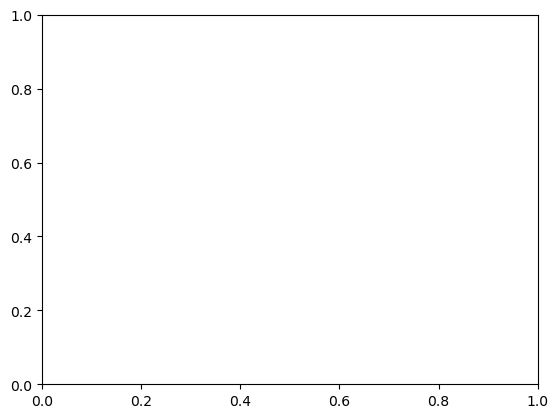

In [5]:
plot_psd(epochs)

In [9]:
epochs.info

<Info | 17 non-empty values
 bads: []
 ch_names: MLC11-3105, MLC12-3105, MLC13-3105, MLC14-3105, MLC15-3105, ...
 chs: 270 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 2429 items (3 Cardinal, 2426 Extra)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 hpi_results: 1 item (list)
 lowpass: 120.0 Hz
 meas_date: 2016-10-13 18:28:00 UTC
 meas_id: 4 items (dict)
 nchan: 270
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 3 items (dict)
>